# Load from drive


## Download dataset and scripts From Drive


In [1]:
from google.colab import drive
import os, glob
import shutil

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
def get_file_size_str(path : str):
  bytesize = os.stat(path).st_size
  if bytesize < 1024:
    return f"{bytesize:.0f} B"
  if bytesize < 1024 * 1024:
    return f"{bytesize / 1024:.0f} KB"
  else:
    return f"{bytesize / (1024 * 1024) :.0f} MB"


def copy_files_recursive(source_folder, destination_folder, dir_exceptions = []):
    for root, dirs, files in os.walk(source_folder):
        dirs[:] = [d for d in dirs if d not in dir_exceptions]
        for file in files:
            if "output" in root:
              continue
            source_path = os.path.join(root, file)
            destination_path = os.path.join(destination_folder, os.path.relpath(source_path, source_folder))

            # Create destination directories if they don't exist
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)

            print(f"Copying {source_path} ({get_file_size_str(source_path)})...", end='')
            shutil.copyfile(source_path, destination_path)
            print("Done")

source_folder = '/content/drive/My Drive/ProgettoCV/'
destination_folder = '/content/'
dir_exceptions = ["output", "occupancy-cnn", "input", "__pycache__"]
copy_files_recursive(source_folder, destination_folder, dir_exceptions)

Copying /content/drive/My Drive/ProgettoCV/ChessLinesClustering.py (13 KB)...Done
Copying /content/drive/My Drive/ProgettoCV/chessboard_detection.py (10 KB)...Done
Copying /content/drive/My Drive/ProgettoCV/chessboard_detection_functions.py (17 KB)...Done
Copying /content/drive/My Drive/ProgettoCV/FEN.py (4 KB)...Done
Copying /content/drive/My Drive/ProgettoCV/input.zip (7109 MB)...Done
Copying /content/drive/My Drive/ProgettoCV/scripts.zip (12 KB)...Done
Copying /content/drive/My Drive/ProgettoCV/output.zip (1660 MB)...Done
Copying /content/drive/My Drive/ProgettoCV/output2.zip (767 MB)...Done
Copying /content/drive/My Drive/ProgettoCV/errors.txt (4 KB)...Done
Copying /content/drive/My Drive/ProgettoCV/modelsaves/CNN_80x80_2Conv_2Pool_2FC.pth (6 MB)...Done
Copying /content/drive/My Drive/ProgettoCV/modelsaves/CNN_80x80_2Conv_2Pool_2FC.txt (79 B)...Done
Copying /content/drive/My Drive/ProgettoCV/modelsaves/CNN_80x80_2Conv_2Pool_2FC_manual_cpu_stopped.pth (0 B)...Done
Copying /content/d

In [4]:
if os.path.exists("/content/scripts.zip"):
  !unzip -u "/content/scripts.zip"
if os.path.exists("/content/input.zip"):
  !unzip -u "/content/input.zip"
if os.path.exists("/content/output2.zip"):
  !unzip -u "/content/output2.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: output/training_pieces/1144_E3.png  
 extracting: output/training_pieces/4159_F2.txt  
 extracting: output/training_pieces/0495_E5.txt  
 extracting: output/training_pieces/3885_H1.txt  
 extracting: output/training_pieces/3037_G1.txt  
 extracting: output/training_pieces/0881_E5.txt  
 extracting: output/training_pieces/3893_B3.txt  
  inflating: output/training_pieces/3363_C8.png  
  inflating: output/training_pieces/3185_B7.png  
 extracting: output/training_pieces/0332_H6.txt  
  inflating: output/training_pieces/0202_F7.png  
  inflating: output/training_pieces/3953_C6.png  
  inflating: output/training_pieces/4885_D4.png  
  inflating: output/training_pieces/0295_H1.png  
 extracting: output/training_pieces/1629_G3.txt  
  inflating: output/training_pieces/2784_G5.png  
 extracting: output/training_pieces/1932_F8.txt  
  inflating: output/training_pieces/0919_A2.png  
 extracting: output/training_pieces/0074_G6.txt  


In [5]:
!pip install chess
from FEN import FEN
from chessboard_detection import *
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00


# Prepare Data Piece Classificator


Script to create training image data for the CNN that classify the bbox images of a piece.

For each single square create:
- Image named as "<dataset image no.>_<square coord>.png"
- Text file "<dataset image no.>_<square coord>.txt" containing the true label

## Script parameters defined by user

Change path according to where you have the dataset folder, default input dir

Change path according to where you prefer having the output

Regex:
- path/1** : start with '1' (1000 to 1999)
- path/** : all

rewrite: Set 'True' to rewrite old already processed images found in the output dir

dataset_percentage: set the ratio of images from the input path that will be used to create the data (when need to train with not too high amount of data or to test a new model). Example: 1 take all the imgs, 0.5 the 50%.

In [ ]:
input_img_path = './input/**'
dst_dir_path = './output/training_pieces/'
rewrite = False
dataset_percentage = 0.75
save_output = False

In [ ]:
import ast
if os.path.exists("errors.txt"):
  with open("errors.txt", "r") as file:
    error_list = ast.literal_eval(file.read())
else:
  error_list = []

In [ ]:
already_processed = glob.glob(f'{dst_dir_path}**')
already_processed = list(set([os.path.splitext(filename)[0].split('/')[-1].split('_')[0] for filename in already_processed]))
print(len(already_processed))
all_input_files = glob.glob(input_img_path)
to_be_processed = [filename for filename in all_input_files
                   if '.json' not in filename
                   and os.path.splitext(filename)[0].split('/')[-1] not in already_processed
                   and os.path.splitext(filename)[0].split('/')[-1] not in error_list
                   ]
len(to_be_processed)

2041


2397

## Prepare to data creation

Prepare dest directory and save which files are already done in already_processed (will be skipped later) and which not in to_be_processed

In [ ]:
os.makedirs(dst_dir_path, exist_ok=True)

already_processed = []
if not rewrite:
  already_processed = glob.glob(f'{dst_dir_path}**')
  already_processed = list(set([os.path.splitext(filename)[0].split('/')[-1].split('_')[0] for filename in already_processed]))
already_processed.sort()

all_input_files = glob.glob(input_img_path)
to_be_processed = [filename for filename in all_input_files
                   if '.json' not in filename
                   and os.path.splitext(filename)[0].split('/')[-1] not in already_processed
                   and os.path.splitext(filename)[0].split('/')[-1] not in error_list
                   ]
cut_index = (len(all_input_files)/2 * dataset_percentage - len(already_processed) - len(error_list))/len(to_be_processed)

cut_index = int(cut_index * len(to_be_processed))
to_be_processed = to_be_processed[:cut_index]
to_be_processed.sort()

if cut_index < 0:
  exceeded = True

print(f"Already processed: {len(already_processed)}")
print(f"To be processed: {len(to_be_processed)}")
print(f"Ignored past errors: {len(error_list)}")


Already processed: 2041
To be processed: 1175
Ignored past errors: 450


## Data Creation

Extract square using chessboard

In [ ]:
num_of_to_be_processed = len(to_be_processed)
num_of_already_processed = 0
last_progress_percentage_shown = 0

for in_process in to_be_processed:
    imgnumber = os.path.splitext(in_process)[0].split('/')[-1]

    # percentage update
    progress_percentage = num_of_already_processed / num_of_to_be_processed * 100
    if progress_percentage - last_progress_percentage_shown > 10:
        last_progress_percentage_shown = progress_percentage
        print(f"########################### progress: {progress_percentage}% ###########################\n")

    #skip if not a file image, if json does not exists, if already present in output
    if not os.path.isfile(in_process):
        continue
    if not in_process.lower().endswith(".png"):
        continue
    print(f"{in_process}...", end=' ')
    if not os.path.isfile(os.path.splitext(in_process)[0] + '.json'):
        print(f"Not found related json({in_process})")
        continue

    # load FEN true label
    truth = FEN(os.path.splitext(in_process)[0])
    true_fen, true_pos, viewpoint = truth.fen, truth.pieces, truth.view

    try:
        # First pass preprocessing
        warpedBoardImg = board_detection(in_process, f"{'output_' + imgnumber}")
        if warpedBoardImg is None:
            num_of_already_processed += 1
            print("Skipped")
            continue

        # Second pass preprocessing
        grid_squares = grid_detection(warpedBoardImg, viewpoint)
        if grid_squares is None:
            print("Skipped")
            num_of_already_processed += 1
            continue

        # Extend the information to include piece information in 3rd col (image remain last in 4th col)
        grid_squares = np.column_stack((grid_squares[:,:2],
                                            [true_pos.get(coord, 'empty') for coord in grid_squares[:, 1]],
                                            grid_squares[:,-2:]
                                            ))

        for square_no, square_coord, piece, square_img, piece_img in grid_squares[:]:
          if piece == 'empty':
            continue
          output_filename = f'{dst_dir_path}{imgnumber}_{square_coord}'
          # .png
          cv2.imwrite(output_filename + '.png', piece_img)

          # .txt
          with open(f'{output_filename}.txt', 'w') as f:
              f.write(true_pos[square_coord] if square_coord in true_pos else 'empty')

        print('Done')
    except:
        output_filename = f'{dst_dir_path}{imgnumber}_error'
        with open(f'{output_filename}.txt', 'w') as f:
                f.write('Error somewhere')

    num_of_already_processed += 1

./input/0000.png... Done
./input/0003.png... Done
./input/0004.png... Not enough lines found, provide a better image
Skipped
./input/0005.png... Done
./input/0007.png... Done
./input/0008.png... Done
./input/0010.png... Done
./input/0012.png... Not enough lines found, provide a better image
Skipped
./input/0013.png... Done
./input/0015.png... Not enough lines found, provide a better image
Skipped
./input/0017.png... Not enough lines found, provide a better image
Skipped
./input/0018.png... Done
./input/0019.png... Not enough lines found, provide a better image
Skipped
./input/0023.png... Done
./input/0025.png... Done
./input/0026.png... Done
./input/0027.png... Done
./input/0029.png... Done
./input/0030.png... Not enough lines found, provide a better image
Skipped
./input/0031.png... Done
./input/0033.png... Done
./input/0034.png... Done
./input/0035.png... Not enough lines found, provide a better image
Skipped
./input/0037.png... Done
./input/0038.png... Done
./input/0039.png... Not e

##Clean square files created by image that raised errors


In [ ]:
errors = glob.glob(f'{dst_dir_path}**error**')

errors = list(set([os.path.splitext(filename)[0].split('/')[-1].split('_')[0] for filename in errors]))
print(f"Found {len(errors)} to be deleted")

for error in errors:
    for filename in glob.glob(f"{dst_dir_path}*{error}*"):
        os.remove(filename)

errors.sort()
print(f"errors deleted: {errors}")

Found 1 to be deleted
errors deleted: ['3356']


In [ ]:
with open("/content/drive/MyDrive/ProgettoCV/errors.txt", "w") as f:
  f.write(str(list(set(error_list + errors))))

##Salvataggio output
Save the outputs in output2.zip, for next time in order to avoid process img again

In [ ]:
save_output

In [ ]:
if save_output:
  !zip -r output2.zip output/
  !cp output2.zip /content/drive/MyDrive/ProgettoCV/output2.zip


Output streaming troncato alle ultime 5000 righe.
  adding: output/training_pieces/1144_E3.png (deflated 1%)
  adding: output/training_pieces/4159_F2.txt (stored 0%)
  adding: output/training_pieces/0495_E5.txt (stored 0%)
  adding: output/training_pieces/3885_H1.txt (stored 0%)
  adding: output/training_pieces/3037_G1.txt (stored 0%)
  adding: output/training_pieces/0881_E5.txt (stored 0%)
  adding: output/training_pieces/3893_B3.txt (stored 0%)
  adding: output/training_pieces/3363_C8.png (deflated 1%)
  adding: output/training_pieces/3185_B7.png (deflated 1%)
  adding: output/training_pieces/0332_H6.txt (stored 0%)
  adding: output/training_pieces/0202_F7.png (deflated 1%)
  adding: output/training_pieces/3953_C6.png (deflated 0%)
  adding: output/training_pieces/4885_D4.png (deflated 1%)
  adding: output/training_pieces/0295_H1.png (deflated 2%)
  adding: output/training_pieces/1629_G3.txt (stored 0%)
  adding: output/training_pieces/2784_G5.png (deflated 1%)
  adding: output/train

# Occupancy classifier
CNN to classify given an input img square if occupied or not by a piece

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [7]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')


## 1. Models

- CNN_80x80_2Conv_2Pool_2FC: input 80x80 x3channels; 2 conv, 2 pool, 2 fully connected; output 2 classes
- other to add and try...

In [ ]:
class ResNet(nn.Module):
    """ResNet model.
    """

    def __init__(self):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights)
        n = self.model.fc.in_features
        self.model.fc = nn.Linear(n, 12)

    def forward(self, x):
        return self.model(x)

In [8]:
class ResNet50(nn.Module):
    """ResNet model.
    """

    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        n = self.model.fc.in_features
        self.model.fc = nn.Linear(n, 12)

    def forward(self, x):
        return self.model(x)

## 2. Prepare and Load dataset

Split data into folders according to their class (empty - no_empty), based on the labels written in the corresponding text files.

In [9]:
for filename in os.listdir('./output/training_pieces/'):

  if filename.endswith('.png'):

    txt_filename = os.path.join('./output/training_pieces/', f"{os.path.splitext(filename)[0]}.txt")

    # Verificare se il file di testo contiene "empty"
    with open(txt_filename, 'r') as file:
      contenuto = file.read()
      os.makedirs(f'./pieces-cnn/data/{contenuto}', exist_ok=True)
      shutil.copy(os.path.join('./output/training_pieces/', filename), os.path.join(f'./pieces-cnn/data/{contenuto}', filename))

In [10]:
num_total_files = sum([len(os.listdir(os.path.join('./pieces-cnn/data/', dir))) for dir in os.listdir('./pieces-cnn/data/')])
for dir in os.listdir('./pieces-cnn/data/'):
  piece_dir = os.path.join('./pieces-cnn/data/', dir)
  # Utilizza len(os.listdir()) per contare il numero di elementi nella cartella
  num_piece = len(os.listdir(piece_dir))
  print(f"{dir}: {num_piece} ({num_piece/num_total_files:.1%})")

b_King: 2037 (5.0%)
b_Bishop: 1994 (4.8%)
b_Pawn: 10746 (26.1%)
w_Knight: 1755 (4.3%)
w_Pawn: 10771 (26.2%)
b_Rook: 2790 (6.8%)
b_Knight: 1813 (4.4%)
w_Rook: 2801 (6.8%)
w_Queen: 1196 (2.9%)
b_Queen: 1176 (2.9%)
w_King: 2040 (5.0%)
w_Bishop: 2015 (4.9%)


Create "data", list of the img paths of the dataset.

Create "labels", list of the corresponding target class label.

Shuffle and split into train, test, validation sets (70-15-15).

In [90]:
dataset_path = './pieces-cnn/data/'
#class_names = os.listdir(dataset_path)
class_names = ['b_Knight', 'w_Knight','w_Queen','b_Queen','b_Rook','w_Bishop','w_Rook','w_Pawn','b_King','w_King','b_Pawn','b_Bishop']
data = []
labels = []
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        data.append(img_path)
        labels.append(class_name)

data, labels = shuffle(data, labels, random_state=4)

# Split the data into training and temporary sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=4)

# Split the temporary set into validation and test sets
test_data, validation_data, test_labels, validation_labels = train_test_split(temp_data, temp_labels, test_size=0.5, stratify=temp_labels, random_state=4)

print(f"train: {len(train_data)}")
print(f"validation: {len(validation_data)}")
print(f"test: {len(test_data)}")

train: 28793
validation: 6171
test: 6170


In [89]:
class_names

['b_King',
 'b_Bishop',
 'b_Pawn',
 'w_Knight',
 'w_Pawn',
 'b_Rook',
 'b_Knight',
 'w_Rook',
 'w_Queen',
 'b_Queen',
 'w_King',
 'w_Bishop']

Prepare dataset for torch (Dataset and DataLoader)

In [91]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Carica l'immagine da file
        img = Image.open(img_path)

        # Applica le trasformazioni se specificate
        if self.transform:
            img = self.transform(img)

        return img, label

In [92]:
transformers = {}

# conv80x80_2_2_2
transformers["CNN_80x80_2Conv_2Pool_2FC"] = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])

# resnet
transformers["ResNet"] = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# 80x160
transformers["80x160"] = transforms.Compose([
    transforms.Resize((80, 160)),
    transforms.ToTensor()
])

In [93]:
model = ResNet50()
modelname = '80x160'

train_ds = CustomDataset(train_data, train_labels, transform=transformers[modelname])
validation_ds = CustomDataset(validation_data, validation_labels, transform=transformers[modelname])
test_ds = CustomDataset(test_data, test_labels, transform=transformers[modelname])

In [94]:
# Crea i dataloader
batch_size = 128
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

## 3. Train Model

In [18]:
# Inizializza la rete
#model = ResNet()
model.to(device)

# Definisci la loss function e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, threshold=0.01, threshold_mode='rel', factor=0.5, verbose=True)

# Definisci il numero di epoche per il training
epochs = 0
num_epochs = 150

# Inizializza le variabili per l'early stopping
best_valid_loss = float('inf')
early_stopping_patience = 7  # Sostituisci con il tuo valore desiderato
early_stopping_counter = 0

# Liste per salvare i valori di loss
train_losses = []
validation_losses = []
model_saves_path = '/content/drive/MyDrive/ProgettoCV/modelsaves/in_training/'

In [ ]:
if os.path.exists(f"{model_saves_path}2-{model._get_name()}_transf_80x160_ep15.tar"):
    checkpoint = torch.load(f"{model_saves_path}2-{model._get_name()}_transf_80x160_ep15.tar", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epochs = checkpoint['epoch']
    loss = checkpoint['loss']
    valid_loss = checkpoint['valid_loss']
    early_stopping_counter = checkpoint['early_stopping_counter']
    train_losses = checkpoint['train_losses']
    validation_losses = checkpoint['validation_losses']
    #train_losses = [1] * epochs + [checkpoint['loss'].item()]
    #validation_losses = [1] * epochs + [checkpoint['valid_loss'].item()]
    print("loaded checkpoint")
    print(epochs)
    print(validation_losses)

loaded checkpoint
15
[1.0222278833389282, 0.4118138551712036, 0.31289607286453247, 0.18498758971691132, 0.4372481107711792, 0.15679147839546204, 0.22875966131687164, 0.1536986529827118, 0.17136108875274658, 0.146820068359375, 0.41290515661239624, 0.15082381665706635, 0.22445616126060486, 0.18530835211277008, 0.12422847747802734, 0.12993286550045013]


In [ ]:
import sys
# Training della rete

for epoch in range(epochs, num_epochs):
    model.train()

    batch_index = 0
    last_progress = 11
    for inputs, labels in train_dataloader:

        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.tensor([class_names.index(label) for label in labels]).to(device))

        loss.backward()
        optimizer.step()

        batch_index += 1
        progress = 10 - int(batch_index / (len(train_data)/128) * 10)
        if progress < last_progress:
            #sys.stdout.write('\r\033[K')  # Move to the beginning of the line and clear it
            print(f"{progress}", end=' ')
            last_progress = progress
            sys.stdout.flush()

    # Valutazione sul set di validazione
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        for inputs, labels in validation_dataloader:
            inputs= inputs.to(device)
            outputs = model(inputs)
            valid_loss += criterion(outputs, torch.tensor([class_names.index(label) for label in labels]).to(device))

    # Calcola la media della loss sul set di validazione
    valid_loss /= len(validation_dataloader)

     # Adjust learning rate using the scheduler
    scheduler.step(valid_loss)

    # Aggiorna le liste di loss
    train_losses.append(loss.item())
    validation_losses.append(valid_loss.item())

    # Controlla se la loss sul set di validazione è migliorata
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stopping_counter = 0
    else:
        # Incrementa il contatore di early stopping
        early_stopping_counter += 1

    sys.stdout.write(f'\r\033[K\n')
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss.item():.4f}, Patience count: {early_stopping_counter}')

    # Se la loss non migliora per un numero specifico di epoche, interrompi il training
    if early_stopping_counter >= early_stopping_patience:
        print(f'Early stopping after {epoch + 1} epochs without improvement.')
        break

    if not epoch % 3:
      os.makedirs(model_saves_path, exist_ok=True)
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss,
          'valid_loss': valid_loss,
          'early_stopping_counter': early_stopping_counter,
          'train_losses': train_losses,
          'validation_losses': validation_losses,
          }, f"{model_saves_path}2-{model._get_name()}_transf_resnet_ep{epoch}.tar")
      print(f"Salvato checkpoint {model_saves_path}2-{model._get_name()}_transf_resnet_ep{epoch}.tar")


Epoch 1/150, Train Loss: 0.1018, Valid Loss: 0.4008, Patience count: 0
Salvato checkpoint /content/drive/MyDrive/ProgettoCV/modelsaves/in_training/2-ResNet50_transf_resnet_ep0.tar

Epoch 2/150, Train Loss: 0.1240, Valid Loss: 0.1536, Patience count: 0

Epoch 3/150, Train Loss: 0.1979, Valid Loss: 0.2074, Patience count: 1
10 

In [ ]:
# Valutazione sul set di validazione
model.eval()
with torch.no_grad():
    valid_loss = 0.0
    for inputs, labels in validation_dataloader:
        inputs= inputs.to(device)
        outputs = model(inputs)
        valid_loss += criterion(outputs, torch.tensor([class_names.index(label) for label in labels]).to(device))

# Calcola la media della loss sul set di validazione
valid_loss /= len(validation_dataloader)

  # Adjust learning rate using the scheduler
scheduler.step(valid_loss)

# Aggiorna le liste di loss
train_losses.append(loss.item())
validation_losses.append(valid_loss.item())

# Controlla se la loss sul set di validazione è migliorata
if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    early_stopping_counter = 0
else:
    # Incrementa il contatore di early stopping
    early_stopping_counter += 1

print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss.item():.4f}, Patience count: {early_stopping_counter}')


""" if not epoch % 3:
  os.makedirs(model_saves_path, exist_ok=True)
  torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      'valid_loss': valid_loss,
      'early_stopping_counter': early_stopping_counter,
      'train_losses': train_losses,
      'validation_losses': validation_losses,
      }, f"{model_saves_path}{model._get_name()}_from_24_cpu_manual.tar")
  print(f"Salvato checkpoint {model_saves_path}{model._get_name()}_from_24_cpu_manual.tar")"""

Epoch 1/150, Train Loss: 0.1521, Valid Loss: 0.3638, Patience count: 0


' if not epoch % 3:\n  os.makedirs(model_saves_path, exist_ok=True)\n  torch.save({\n      \'epoch\': epoch,\n      \'model_state_dict\': model.state_dict(),\n      \'optimizer_state_dict\': optimizer.state_dict(),\n      \'loss\': loss,\n      \'valid_loss\': valid_loss,\n      \'early_stopping_counter\': early_stopping_counter,\n      \'train_losses\': train_losses,\n      \'validation_losses\': validation_losses,\n      }, f"{model_saves_path}{model._get_name()}_from_24_cpu_manual.tar")\n  print(f"Salvato checkpoint {model_saves_path}{model._get_name()}_from_24_cpu_manual.tar")'

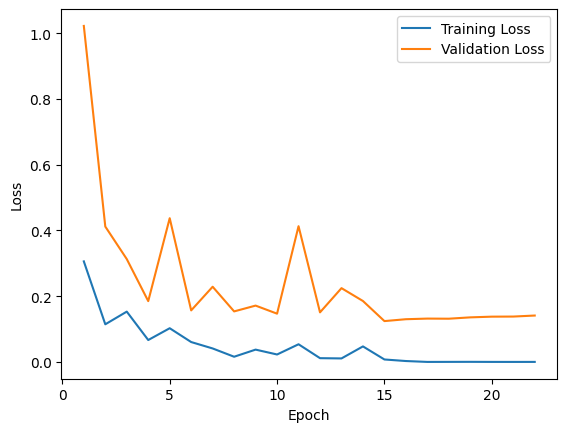

In [ ]:
import matplotlib.pyplot as plt


# Plot dei valori di training loss e validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test Model
Test the model on test data and evaluate accuracy

In [ ]:
# Test della rete
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs, 1)
        total += len(labels)
        correct += (predicted == torch.tensor([class_names.index(label) for label in labels]).to(device)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 98.15%


##Save Model
Save the model on drive for future restesting or use for prediction. Save a text file with info about the model.


---


example:

Saved CNN_80x80_2Conv_2Pool_2FC.pth

Saved CNN_80x80_2Conv_2Pool_2FC.txt

<br>CNN_80x80_2Conv_2Pool_2FC.txt:
>Acc: 74.23%
<br>Date: 12/03/2024 10:52
<br>
<br>On data:
<br>	Train: 4200
<br>Validation: 900
<br>Test: 900



In [ ]:
def get_unique_filename(base_filename):
    filename, file_extension = os.path.splitext(base_filename)
    index = 0
    new_filename = base_filename
    while os.path.exists(new_filename):
        new_filename = f"{filename}_{str(index).zfill(4)}{file_extension}"
        index += 1
    return new_filename, index

In [ ]:
from datetime import datetime

model_saves_path = './drive/MyDrive/ProgettoCV/modelsaves/'
os.makedirs(model_saves_path, exist_ok=True)

current_datetime = datetime.now().strftime("%d/%m/%Y %H:%M")

# NOTE: forse conviene save(model) invece di model.state_dict perche' intanto non
#       abbiamo operazioni particolari, solo fare load()

filename_base = f"{model_saves_path}2-{model._get_name()}"
filename_model, i = get_unique_filename(f"{filename_base}.pth")
filename_model_info, j = get_unique_filename(f"{filename_base}.txt")
if i != j:
  raise Exception(f'Unwanted error on naming files: \n\t{filename_model}\n\t{filename_model_info}')

torch.save(model, f"{filename_model}")
print(f"Saved {filename_model}")

with open(f"{filename_model_info}", "w") as file:
  file.write(f"Acc: {accuracy * 100:.2f}%\n")
  file.write(f"Date: {current_datetime}\n")

  file.write("\nOn data:\n")
  file.write(f"\tTrain: {len(train_data)}\n")
  file.write(f"\tValidation: {len(validation_data)}\n")
  file.write(f"\tTest: {len(test_data)}\n")
print(f"Saved {filename_model_info}")


Saved ./drive/MyDrive/ProgettoCV/modelsaves/2-ResNet50.pth
Saved ./drive/MyDrive/ProgettoCV/modelsaves/2-ResNet50.txt


##Load and test Saved Models

In [21]:
model = torch.load(f"/content/modelsaves/2-ResNet50.pth", map_location="cpu")

In [22]:
transformers = {}

# conv80x80_2_2_2
transformers["CNN_80x80_2Conv_2Pool_2FC"] = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])

# resnet
transformers["ResNet"] = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


In [23]:
modelname = 'ResNet'

train_ds = CustomDataset(train_data, train_labels, transform=transformers[modelname])
validation_ds = CustomDataset(validation_data, validation_labels, transform=transformers[modelname])
test_ds = CustomDataset(test_data, test_labels, transform=transformers[modelname])

In [24]:
# Crea i dataloader
batch_size = 128
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [96]:
# Test della rete
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        #if total > 500:
        #  break
        outputs = model(inputs.to(device))
        _, predicted = torch.max(outputs, 1)
        total += len(labels)
        correct += (predicted == torch.tensor([class_names.index(label) for label in labels]).to(device)).sum().item()
        break

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 3.12%


In [85]:
class_names[11]='b_Bishop'
class_names[5]='w_Bishop'
for i, classname in enumerate(class_names):
  print(i, classname)

0 b_Knight
1 w_Knight
2 w_Queen
3 b_Queen
4 b_Rook
5 w_Bishop
6 w_Rook
7 w_Pawn
8 b_King
9 w_King
10 b_Pawn
11 b_Bishop


In [84]:
img_path = '/content/pieces-cnn/data/b_Bishop/0010_B7.png'

img = Image.open(img_path)

img = transformers["80x160"](img)
display(img.shape)

img = img.reshape([1, 3, 80, 160])

with torch.no_grad():
    output = model(img)
    display(output)
    display(torch.max(output, 1))

torch.Size([3, 80, 160])

tensor([[-13.6992, -21.7639, -27.5015,  -1.6791, -15.1753,  -5.6550, -27.4920,
         -21.7535,  -5.3161, -23.6508,  -3.8095,  16.5468]])

torch.return_types.max(
values=tensor([16.5468]),
indices=tensor([11]))